In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime # to time processes
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

### Basic EDA

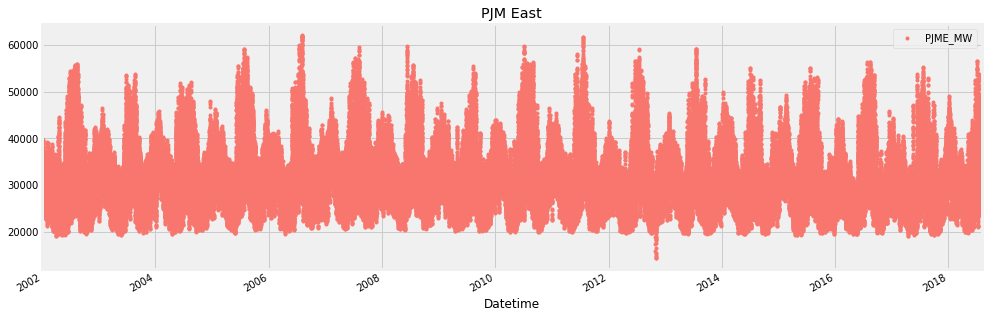

In [3]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### Train/Test Split

In [4]:
split_date = '01-JAN-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

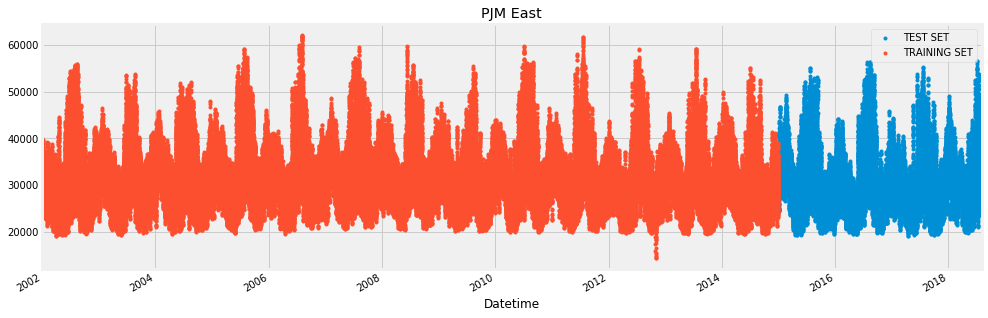

In [5]:
temp_plot = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

### Create Features

In [6]:
def create_features(df, label=None):
    """Creates time series from a datetime index"""
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    
    return X
    

In [7]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

### Create RFR Models and Predict

In [8]:
# Model 1 - Depth 2
start = datetime.datetime.now()
reg = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
reg.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg (depth=2, estimators=100): ", end-start)

Total runtime for reg (depth=2, estimators=100):  0:00:03.126612


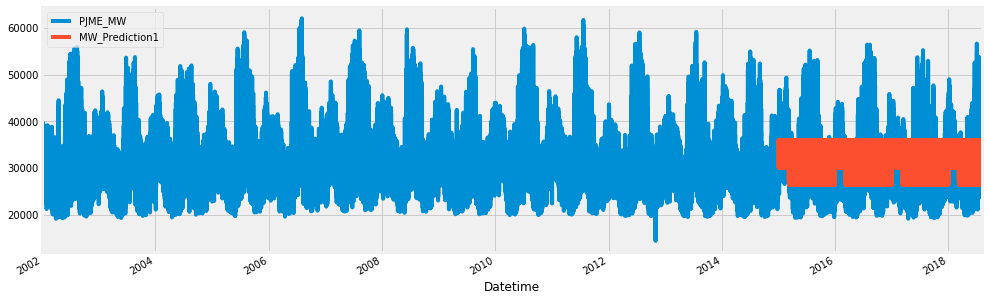

In [9]:
# Plot Reg 1
pjme_test['MW_Prediction1'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
temp_plot = pjme_all[['PJME_MW','MW_Prediction1']].plot(figsize=(15, 5))

In [10]:
# Model 2 - Depth 10
start = datetime.datetime.now()
reg2 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
reg2.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg2 (depth=10, estimators=100): ", end-start)

Total runtime for reg2 (depth=10, estimators=100):  0:00:11.204034


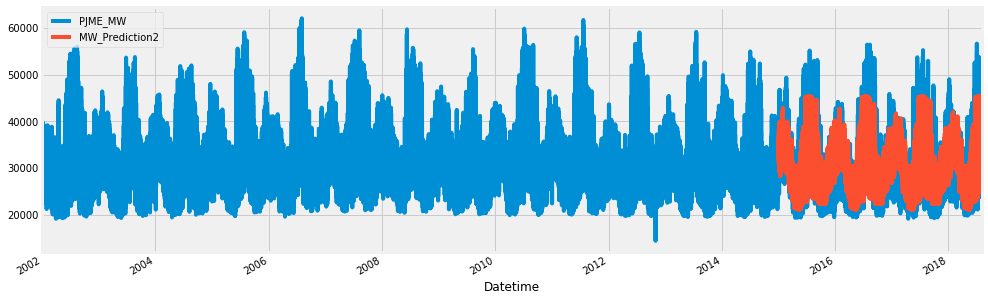

In [12]:
# Plot Reg 2
pjme_test['MW_Prediction2'] = reg2.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
temp_plot = pjme_all[['PJME_MW','MW_Prediction2']].plot(figsize=(15, 5))

In [13]:
# Model 3 - Depth 10
start = datetime.datetime.now()
reg3 = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=1000)
reg3.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg2 (depth=2, estimators=1000): ", end-start)

Total runtime for reg2 (depth=2, estimators=1000):  0:00:30.155565


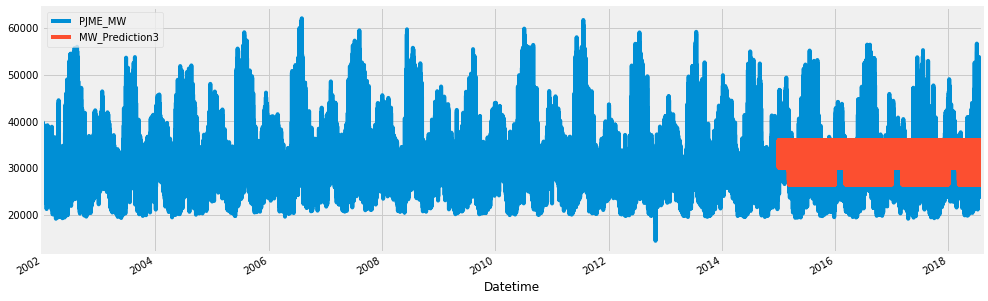

In [14]:
# Plot Reg 3
pjme_test['MW_Prediction3'] = reg3.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
temp_plot = pjme_all[['PJME_MW','MW_Prediction3']].plot(figsize=(15, 5))

In [15]:
# Model 4 - Depth = 10, Estimators = 1000
start = datetime.datetime.now()
reg4 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=1000)
reg4.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total runtime for reg3 (depth=10, estimators=1000): ", end-start)

Total runtime for reg3 (depth=10, estimators=1000):  0:01:57.002488


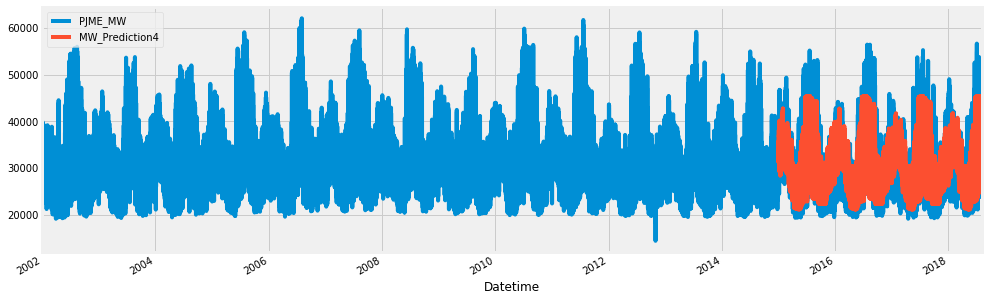

In [16]:
# Plot Reg 4
pjme_test['MW_Prediction4'] = reg4.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
temp_plot = pjme_all[['PJME_MW','MW_Prediction4']].plot(figsize=(15, 5))

### Evaluate Model Performance

In [21]:
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for i in ['MW_Prediction1', 'MW_Prediction2', 'MW_Prediction3', 'MW_Prediction4']:
    print(i)
    print("MSE: ", mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
    print("RMSE: ", math.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i])))
    print("MAE: ", mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
    print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(pjme_test['PJME_MW'], pjme_test[i]), 4)))
    print("\n")
    
    

MW_Prediction1
MSE:  29858002.954190187
RMSE:  5464.247702492099
MAE:  4487.900380620723
Mean Absolute Percentage Error: 14.5432%


MW_Prediction2
MSE:  15275508.450175289
RMSE:  3908.3894957098746
MAE:  2984.6497306626934
Mean Absolute Percentage Error: 9.449%


MW_Prediction3
MSE:  29860274.85607468
RMSE:  5464.455586430791
MAE:  4487.965795766639
Mean Absolute Percentage Error: 14.5432%


MW_Prediction4
MSE:  15273986.209275499
RMSE:  3908.1947506841952
MAE:  2985.4988577001373
Mean Absolute Percentage Error: 9.4533%




In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])